In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
TEST_IMAGES = []
for i in range(6):
    TEST_IMAGES.append('./test_images/test{0}.jpg'.format(i+1))

class CameraCalibration:

    def __init__(self, calib_image_dir, chessboard_size):
        self.chessboard_size = chessboard_size
        self.calib_image_dir = calib_image_dir
        self.objectPoints = []
        self.imagePoints = []
        self.prev_imageSize = None
        self.camera_matrix = None
        self.distCoeffs = None

        self.setCalibrationPoints()

    def setCalibrationPoints (self):
        
        # define 3d object point of chessboard_size 
        objectP = np.zeros((self.chessboard_size[0]*self.chessboard_size[1], 3), np.float32)
        objectP[:,:2] = np.mgrid[0:self.chessboard_size[0], 0:self.chessboard_size[1]].T.reshape(-1, 2)
        images = glob.glob(self.calib_image_dir + '*')

        for fname in images:
            image = cv2.imread(fname)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            #find corners from the chessboard images
            ret, corners = cv2.findChessboardCorners(gray, self.chessboard_size, None)

            if ret == True:
                self.objectPoints.append(objectP)
                self.imagePoints.append(corners)

                cv2.drawChessboardCorners(image, self.chessboard_size, corners, ret)

    def undistortImage (self, image):
        imageSize = (image.shape[1], image.shape[0])
        if (not self.prev_imageSize or self.prev_imageSize != imageSize):
            #compute camera matrix and distortion coefficients
            print('Calibrating image...')
            ret, self.camera_matrix, self.distCoeffs, rvecs, tvecs = cv2.calibrateCamera(self.objectPoints, self.imagePoints, imageSize, None, None)
            self.prev_imageSize = imageSize

        undistorted_image = cv2.undistort(image, self.camera_matrix, self.distCoeffs, None, self.camera_matrix)

        return undistorted_image
    
cameraCalibration = CameraCalibration('./camera_cal/', (9, 6))

In [31]:
def displayImage(image, row=3, figsize=(10, 16)):
    try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.axis('off')
        plt.imshow(image)
        plt.show()
    except:
        fig=plt.figure(figsize=figsize)
        for i in range(len(image)):
            fig.add_subplot(len(image)//row + 1, row, i+1)
            plt.axis('off')
            plt.imshow(cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB))
        plt.show()
    
def loadImage(imagePath):
    return cv2.imread(imagePath)

def convertGray (image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def calibrateImage (image):
    return cameraCalibration.undistortImage(image)

In [94]:
def detectYellow (image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    binary = np.zeros_like(hsv_image[:, :, 0])
    h, s, v = hsv_image[:, :, 0], hsv_image[:, :, 1], hsv_image[:, :, 2]
    binary[(h<=30) & (h>=20) & (s<=255) & (s>=90) & (v>=90) & (v<=255)] = 255
    
    return binary

def detectWhite (image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    binary = np.zeros_like(hsv_image[:, :, 0])
    h, s, v = hsv_image[:, :, 0], hsv_image[:, :, 1], hsv_image[:, :, 2]
    binary[(h>=0) & (h<=255) & (s>=0) & (s<=30) & (v>=225) & (v<=255)] = 255
    
    return binary

def detectWhiteAndYellow (image):
    yellow = detectYellow(image)
    white = detectWhite(image)
    
    white_yellow = np.zeros_like(yellow)
    white_yellow[(yellow == 255) | (white==255)] = 255
    return white_yellow

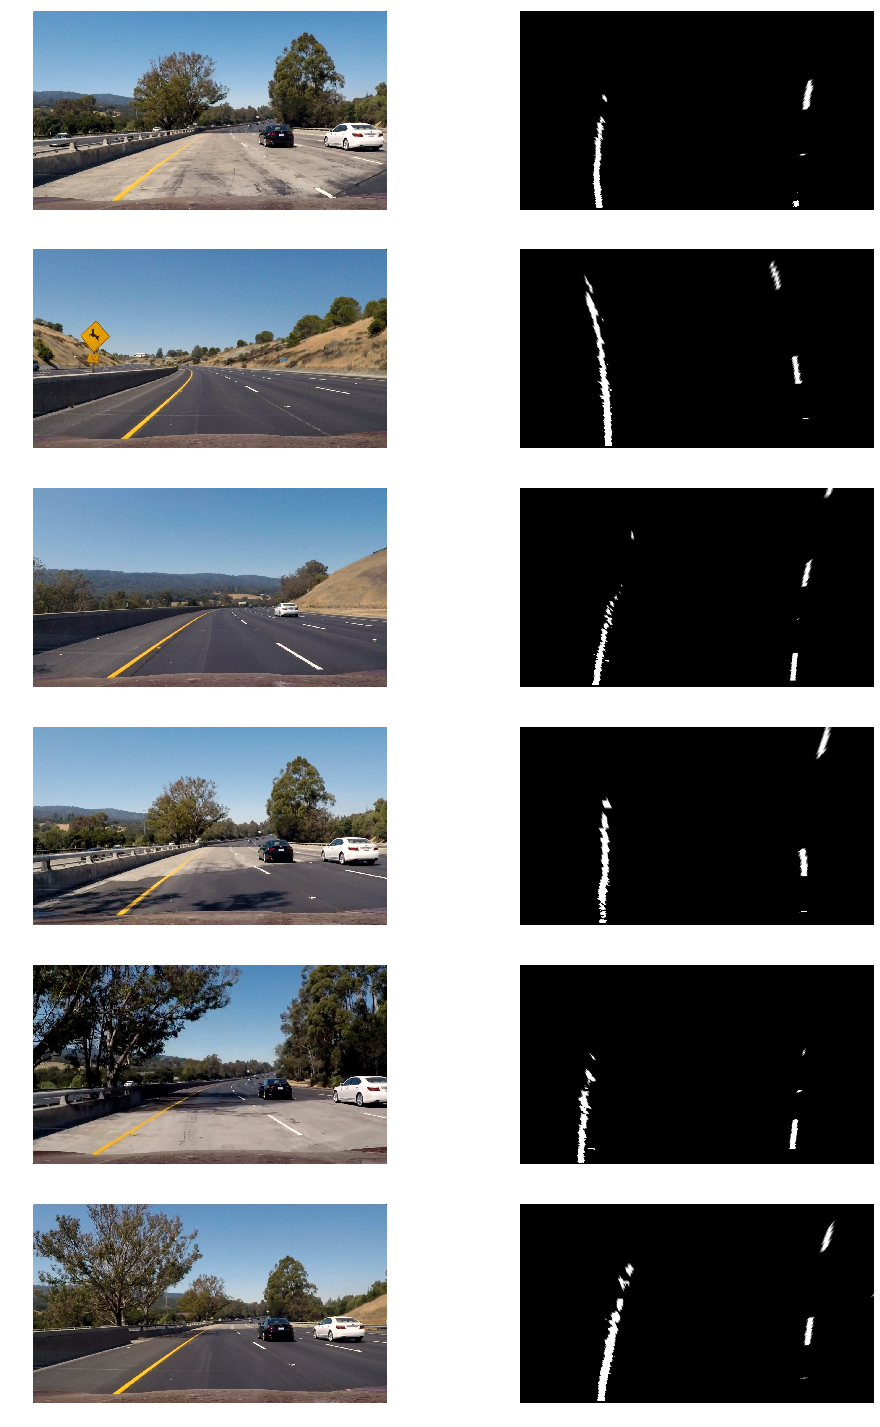

In [96]:
src = np.float32([[580, 460], [205, 720], [1110, 720], [703, 460]])
dst = np.float32([[250, 0], [250, 720], [960, 720], [960, 0]])
def getBirdEyeView (image):
    M = cv2.getPerspectiveTransform(src, dst)
    image_size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)

    
def getMInv ():
    return cv2.getPerspectiveTransform(dst, src)

images = []
for imagePath in TEST_IMAGES:
#     image = detectWhiteAndYellow(calibrateImage(loadImage(imagePath)))
    image = loadImage(imagePath)
    images.append(image)
    images.append(getBirdEyeView(detectWhiteAndYellow(calibrateImage(image))))

displayImage(images, 2, (16, 30))